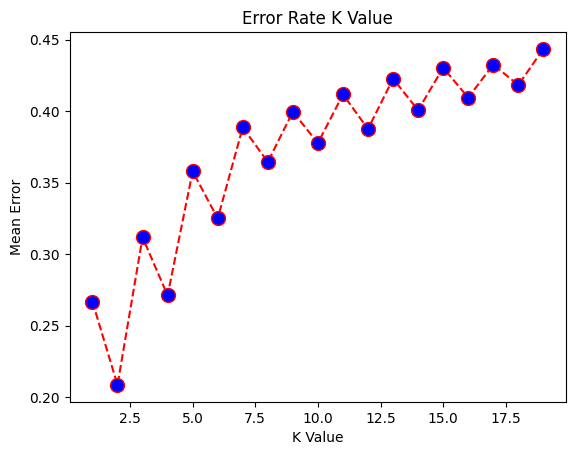

accuracy_score: 0.62

Clasification report:
               precision    recall  f1-score   support

           0       0.94      0.62      0.74       807
           1       0.18      0.67      0.29       104

    accuracy                           0.62       911
   macro avg       0.56      0.64      0.52       911
weighted avg       0.85      0.62      0.69       911


Confusion matrix:
 [[497 310]
 [ 34  70]]


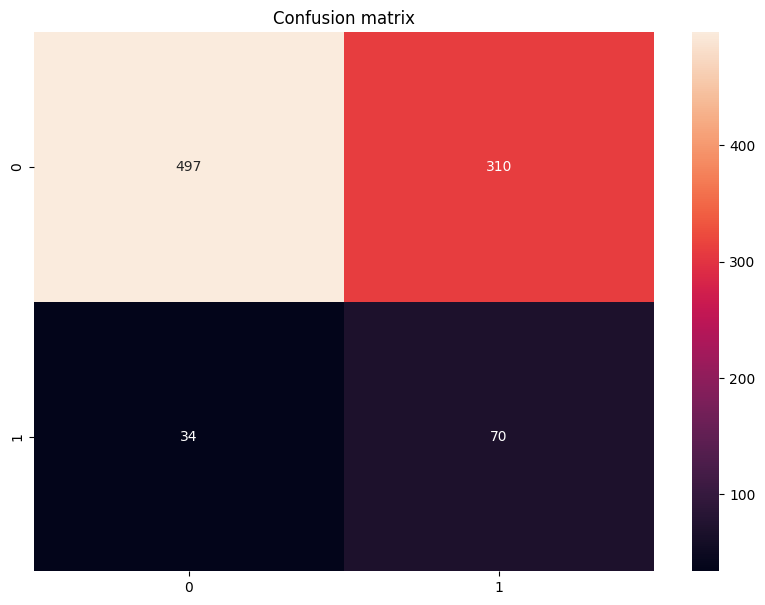


cv_scores mean:0.892700372330002

cv_score variance:1.0073113113445304e-05

cv_score dev standard:0.003173816805274889


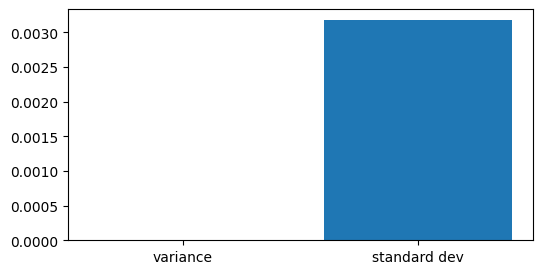


AUC: 0.705


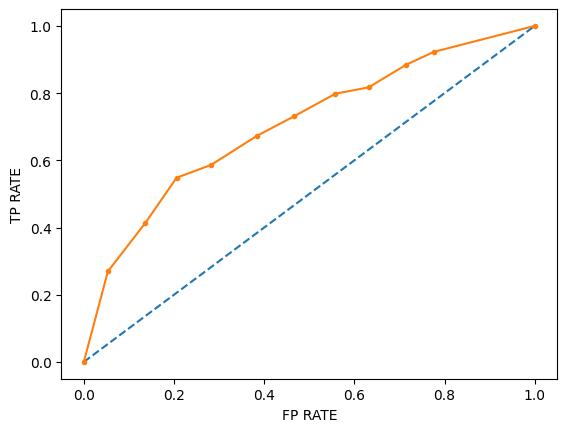

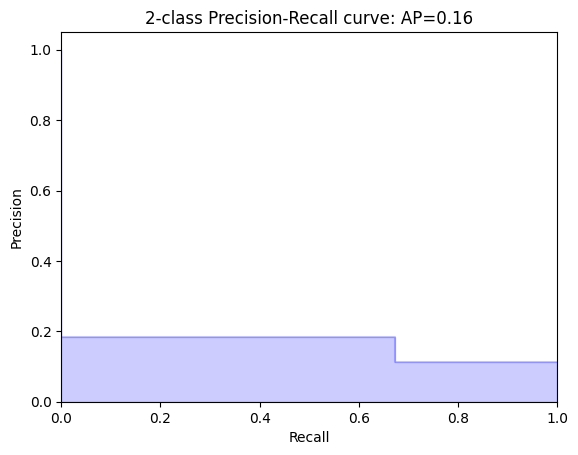

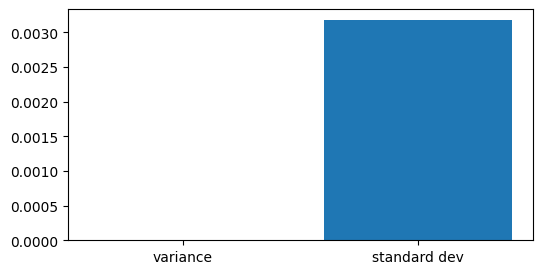

In [11]:
"""
Questo script analizza un dataset sull'autismo utilizzando il classificatore dei k-nn.
Viene effettuato il caricamento dei dati, la loro elaborazione, l'addestramento del modello,
e l'analisi delle sue prestazioni attraverso metriche e grafici.
"""

import numpy as np, pandas as pd, seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Funzione per la pulizia e trasformazione dei dati

def clean_data(data):
    """Converte le colonne stringa in numerico e mappa i valori categorici."""
    for col in data.columns:
        data[col] = data[col].astype('string')
        data[col] = data[col].astype('float', errors='ignore')

    data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 2})
    data['Dyslexia'] = data['Dyslexia'].map({'No': 0, 'Yes': 1})
    data['Nativelang'] = data['Nativelang'].map({'No': 0, 'Yes': 1})
    data['Otherlang'] = data['Otherlang'].map({'No': 0, 'Yes': 1})

# Caricamento dataset
desktop_data = pd.read_csv("/content/Dyslexia_dataset.csv", sep=';', encoding='utf-8')
clean_data(desktop_data)

# Selezione delle colonne di interesse
features = ['Gender', 'Nativelang', 'Otherlang', 'Age', 'Dyslexia']
for i in range(30):
    if (i in list(range(12)) + list(range(13, 17)) + [21, 22, 29]):
        for metric in ['Clicks', 'Hits', 'Misses', 'Score', 'Accuracy', 'Missrate']:
            features.append(f'{metric}{i+1}')

desktop_data = desktop_data[features]

# Separazione delle variabili dipendenti e indipendenti
y = desktop_data['Dyslexia']
X = desktop_data.drop(columns=['Dyslexia'])

# Divisione dei dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 13)

# Applicazione di SMOTE per bilanciare le classi
oversample = SMOTE()
X1, y1 = oversample.fit_resample (X_train, y_train)

#------------------------------------------------------------------------------------------------------------------------------
error = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X1, y1)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

#Grafico che mostra l'errore medio nelle predizioni a seguito di una variazione del valore K(numero vicini)
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize = 10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()
#------------------------------------------------------------------------------------------------------------------------------

# Addestramento del modello con il valore ottimale di K
neigh = KNeighborsClassifier(n_neighbors = 10)
knn = neigh.fit(X1, y1)

# Effettua previsioni sul test set
prediction = knn.predict(X_test)
accuracy = accuracy_score(prediction, y_test)
print(f"accuracy_score: {accuracy:.2f}")

# Stampa del rapporto di classificazione e della matrice di confusione
print ('\nClasification report:\n',classification_report(y_test, prediction))
print ('\nConfusion matrix:\n',confusion_matrix(y_test, prediction))

# Creazione e visualizzazione della matrice di confusione come heatmap
confusion_matrix = confusion_matrix(y_test, prediction)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion matrix')
plt.show()

# Valutazione del modello attraverso cross-validation (di 5)
cv_scores = cross_val_score(neigh, X, y, cv=5)

# Stampa delle statistiche ottenute dalla cross-validation
print('\ncv_scores mean:{}'.format(np.mean(cv_scores)))
print('\ncv_score variance:{}'.format(np.var(cv_scores)))
print('\ncv_score dev standard:{}'.format(np.std(cv_scores)))

# Creazione di un grafico per visualizzare varianza e deviazione standard dei cv_scores
data = {'variance': np.var(cv_scores), 'standard dev': np.std(cv_scores)}
names = list(data.keys())
values = list(data.values())
fig,axs = plt.subplots(1, 1, figsize=(6, 3), sharey=True)
axs.bar(names, values)
plt.show()

# Calcolo delle probabilità e dell'AUC per la curva ROC
probs = knn.predict_proba(X_test)
probs = probs[:, 1]

# Calcolo e visualizzazione della curva ROC
auc = roc_auc_score(y_test, probs)
print('\nAUC: %.3f' % auc)
# calcolo roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
pyplot.xlabel('FP RATE')
pyplot.ylabel('TP RATE')
pyplot.show()

# Calcolo dell'average precision e visualizzazione della curva precision-recall
average_precision = average_precision_score(y_test, prediction)
precision, recall, _ = precision_recall_curve(y_test, prediction)

# In matplotlib < 1.5, plt.fill_betwee non dispone dell'argomento 'step'
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

# Calcolo dell'F1-score
f1= f1_score(y_test, prediction)

# Creazione di un grafico per visualizzare varianza e deviazione standard dei cv_scores
data = {'variance': np.var(cv_scores), 'standard dev': np.std(cv_scores)}
names = list(data.keys())
values = list(data.values())
fig,axs = plt.subplots(1, 1, figsize=(6, 3), sharey=True)
axs.bar(names, values)
plt.show()